# Load file names

In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
DATA_PATH = '/kaggle/input'
SAMPLE_RATE = 48000
# means the audio data will be processed or analyzed at 48,000 samples per second

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender', 'Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/kaggle/input', dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = int(identifiers[2])
        if emotion == 8:
            emotion = 0
        emotion_intensity = 'normal' if int(identifiers[3]) == 1 else 'strong'
        gender = 'female' if int(identifiers[6]) % 2 == 0 else 'male'
        
        new_row = pd.DataFrame({
            "Emotion": [emotion],
            "Emotion intensity": [emotion_intensity],
            "Gender": [gender],
            "Path": [file_path]
        })
        data = pd.concat([data, new_row], ignore_index=True)

print(data)


     Emotion Emotion intensity  Gender  \
0          0            normal  female   
1          1            normal  female   
2          7            strong  female   
3          7            normal  female   
4          1            normal  female   
...      ...               ...     ...   
2875       6            normal    male   
2876       5            normal    male   
2877       4            strong    male   
2878       7            strong    male   
2879       5            strong    male   

                                                   Path  
0     /kaggle/input/ravdess-emotional-speech-audio/A...  
1     /kaggle/input/ravdess-emotional-speech-audio/A...  
2     /kaggle/input/ravdess-emotional-speech-audio/A...  
3     /kaggle/input/ravdess-emotional-speech-audio/A...  
4     /kaggle/input/ravdess-emotional-speech-audio/A...  
...                                                 ...  
2875  /kaggle/input/ravdess-emotional-speech-audio/A...  
2876  /kaggle/input/ravdess-emo

In [2]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 2880


,Emotion,Emotion intensity,Gender,Path
0,0,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
1,1,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
2,7,strong,female,/kaggle/input/ravdess-emotional-speech-audio/A...
3,7,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
4,1,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...


Number of examples per emotion

Text(0, 0.5, 'Number of examples')

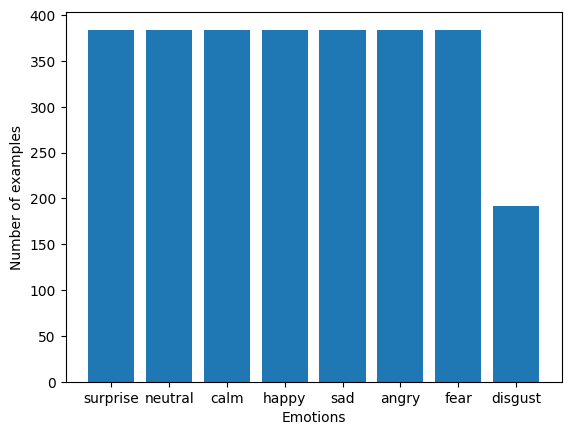

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')

number of examples per gender

Text(0, 0.5, 'Number of examples')

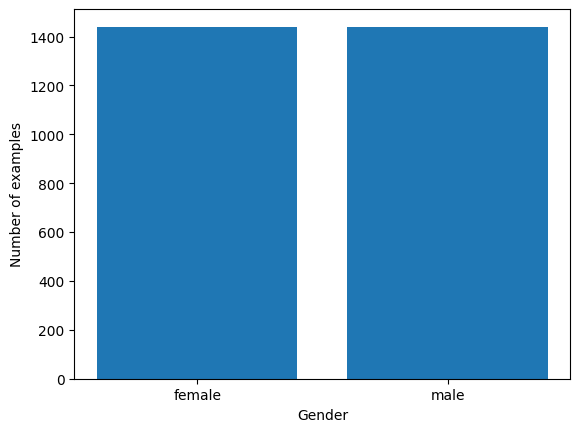

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Gender'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

number of examples per emotion intensity

Text(0, 0.5, 'Number of examples')

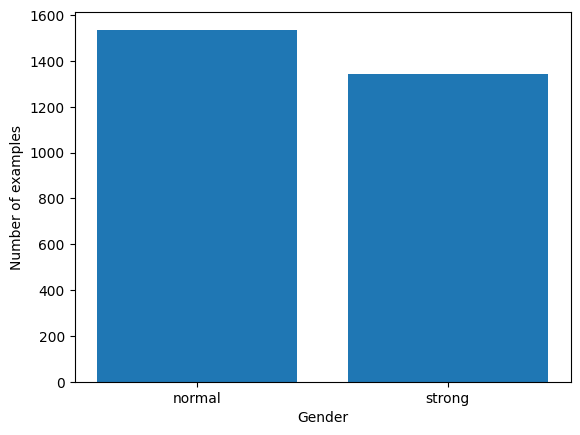

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Emotion intensity'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

# Load the signals

In [6]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

# This code processes audio files by loading 3-second segments starting from 0.5 seconds into each file, 
# ensuring all signals are of the same length (3 seconds), and storing them in a numpy array.

 Processed 2879/2880 files

# Split the data

In [7]:
X = signals  # Assign Signals to X
train_ind,test_ind,val_ind = [],[],[] # initializing lists
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):   # Split Data by Emotion
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)  # Concatenate the lists of arrays into single numpy arrays for training, validation, and test sets.
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')  # Print Shapes
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(2302, 144000), Y_train:(2302,)
X_val:(285, 144000), Y_val:(285,)
X_test:(293, 144000), Y_test:(293,)
Number of unique indexes is 2880, out of 2880


# Augment signals by adding AWGN

In [8]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
# signal: The input audio signal to which noise will be added.
# num_bits: Number of bits for quantization (default is 16).
# augmented_num: Number of augmented signals to generate (default is 2).
# snr_low: Lower bound for the signal-to-noise ratio (SNR) in dB (default is 15).
# snr_high: Upper bound for the SNR in dB (default is 30).
    signal_len = len(signal)

    # Generate White Gaussian noise with the same length as the signal
    # augmented_num sets how many noise samples to generate (2)
    noise = np.random.normal(size=(augmented_num, signal_len))

    # Normalize the signal and noise based on the quantization level
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant

    # Calculate the power of the normalized signal and noise
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len

    # Generate a random SNR value between 15 and 30
    target_snr = np.random.randint(snr_low, snr_high)

    # Calculate the scaling factor K (covariance matrix) for the noise to achieve the target SNR.
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    
    # Add the scaled noise to the original signal to generate the noisy signal
    return signal + K.T * noise

In [9]:
aug_signals = []                                          # List to store augmented signal
aug_labels = []                                           # List to store labels corresponding to the augmented signals
for i in range(X_train.shape[0]):                         # generate augmented signals with added noise loop through each signal in X_train
    signal = X_train[i, :]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(Y_train[i])
        aug_signals.append(augmented_signals[j])
    print("\rProcessed {}/{} files".format(i + 1, X_train.shape[0]), end='')

aug_signals = np.stack(aug_signals, axis=0)               # Convert the list of augmented signals to a numpy array
X_train = np.concatenate([X_train, aug_signals], axis=0)  # Concatenate the original X_train with the augmented signals
aug_labels = np.stack(aug_labels, axis=0)                 # Convert the list of augmented labels to a numpy array
Y_train = np.concatenate([Y_train, aug_labels])           # Concatenate the original Y_train with the augmented labels

print('')
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')   # Print the shapes of the updated X_train and Y_train to verify the sizes after augmentation


Processed 2302/2302 files
X_train: (6906, 144000), Y_train: (6906,)


# Calculate mel spectrograms

MEL spectrogram shape:  (128, 563)


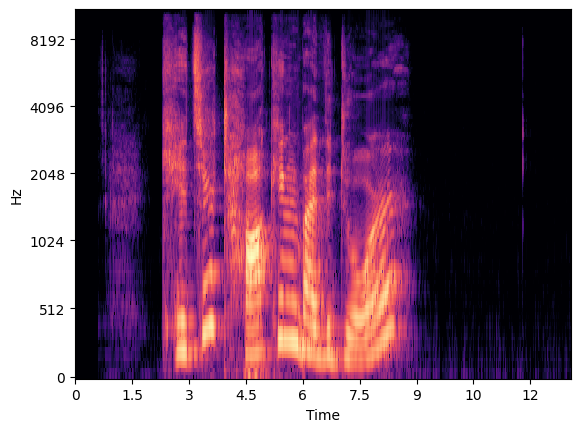

In [10]:
def getMELspectrogram(audio, sample_rate):               # the function getMELspectrogram to compute the Mel spectrogram of an audio signal and convert it to dB units
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function - tested by loading an audio file, preparing the signal, computing its Mel spectrogram, displaying the spectrogram, and printing its shape
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [11]:
mel_train = []
print("Calculatin mel spectrograms for train set")    # Compute Mel Spectrograms for Training Set
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
mel_train = np.stack(mel_train,axis=0)              # Convert mel_train to a numpy array using np.stack
del X_train                                         # Delete the original X_train to save memory
X_train = mel_train                                 # Replace X_train with the Mel spectrograms

mel_val = []
print("Calculatin mel spectrograms for val set")     # Compute Mel Spectrograms for Validation Set
for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
mel_val = np.stack(mel_val,axis=0)
del X_val
X_val = mel_val

mel_test = []
print("Calculatin mel spectrograms for test set")   # Compute Mel Spectrograms for Test Set
for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
mel_test = np.stack(mel_test,axis=0)
del X_test
X_test = mel_test

print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# Print the shapes of X_train, X_val, and X_test to confirm the dimensions after conversion to Mel spectrograms

Calculatin mel spectrograms for train set
 Processed 6905/6906 files
Calculatin mel spectrograms for val set
 Processed 284/285 files
Calculatin mel spectrograms for test set
 Processed 292/293 files
X_train:(6906, 128, 563), Y_train:(6906,)
X_val:(285, 128, 563), Y_val:(285,)
X_test:(293, 128, 563), Y_test:(293,)


# Create the model

In [12]:
import torch
import torch.nn as nn

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
            # 2. conv block
            nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.5),
            # 3. conv block
            nn.Conv2d(in_channels=32,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.5),
            # 4. conv block
            nn.Conv2d(in_channels=64,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.5)
        )
        # LSTM block
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 128
        self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.3)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        # Linear softmax layer
        self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
        self.dropout_linear = nn.Dropout(p=0.3)
        self.out_softmax = nn.Softmax(dim=1)
    def forward(self,x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape 
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        # concatenate
        complete_embedding = torch.cat([conv_embedding, attention], dim=1) 
        
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, attention_weights_norm
                                     

In [13]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)
    # this function computes the loss between predictions and targets

# TRAINING

In [14]:
def make_train_step(model, loss_fnc, optimizer):            #  create a training step function, which can then be used in a training loop to train the model
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax,dim=1)     # Get predictions by choosing the class with the highest probability
        accuracy = torch.sum(Y==predictions)/float(len(Y))   # Compute accuracy
       
        loss = loss_fnc(output_logits, Y)                    # compute loss
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [15]:
def make_validate_fnc(model,loss_fnc):                 # Creates a validation function that evaluates the model on a given dataset
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

scale data

In [16]:
print("Shape of mel_spectrogram before scaling:", mel_spectrogram.shape)


Shape of mel_spectrogram before scaling: (128, 563)


In [17]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (6906, 128, 563)
X_val shape: (285, 128, 563)
X_test shape: (293, 128, 563)


In [18]:
from sklearn.preprocessing import StandardScaler   # data preprocessing using StandardScaler from scikit-learn
import numpy as np

# Expand dimensions to add a channel dimension
#  Adds a channel dimension to the data, converting the data shape from (batch_size, height, width) to (batch_size, channels, height, width)
X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

# Initialize the scaler for normalization
# Ensuring that all features contribute equally to the model's learning process
scaler = StandardScaler()

# Get the dimensions of the data
b, c, h, w = X_train.shape

# Reshape the data to 2D (batch_size, -1) for fitting the scaler
X_train = np.reshape(X_train, newshape=(b, -1))

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Reshape the scaled training data back to 4D (batch_size, channels, height, width)
X_train = np.reshape(X_train, newshape=(b, c, h, w))

# Print shapes of scaler parameters to verify
print("Shape of scaler mean:", scaler.mean_.shape)
print("Shape of scaler scale:", scaler.scale_.shape)

# Save the scaler's mean and scale
np.save('scaler_mean.npy', scaler.mean_)
np.save('scaler_scale.npy', scaler.scale_)

# Transform the test data
b, c, h, w = X_test.shape
X_test = np.reshape(X_test, newshape=(b, -1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b, c, h, w))

# Transform the validation data
b, c, h, w = X_val.shape
X_val = np.reshape(X_val, newshape=(b, -1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b, c, h, w))


Shape of scaler mean: (72064,)
Shape of scaler scale: (72064,)


In [19]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (6906, 1, 128, 563)
X_val shape: (285, 1, 128, 563)
X_test shape: (293, 1, 128, 563)


In [20]:
print("Shape of mel_spectrogram after scaling:", mel_spectrogram.shape)


Shape of mel_spectrogram after scaling: (128, 563)


Train the model

In [21]:
EPOCHS=50
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")
    

Selected device is cpu
Number of trainable params:  263593
 Epoch 0: iteration 214/215
Epoch 0 --> loss:2.3251, acc:18.51%, val_loss:2.0161, val_acc:18.60%
 Epoch 1: iteration 214/215
Epoch 1 --> loss:1.9853, acc:23.89%, val_loss:1.9282, val_acc:19.30%
 Epoch 2: iteration 214/215
Epoch 2 --> loss:1.8537, acc:28.63%, val_loss:1.7888, val_acc:34.74%
 Epoch 3: iteration 214/215
Epoch 3 --> loss:1.7930, acc:30.22%, val_loss:1.7373, val_acc:36.14%
 Epoch 4: iteration 214/215
Epoch 4 --> loss:1.7353, acc:32.45%, val_loss:1.6922, val_acc:38.60%
 Epoch 5: iteration 214/215
Epoch 5 --> loss:1.6771, acc:35.11%, val_loss:1.6428, val_acc:39.30%
 Epoch 6: iteration 214/215
Epoch 6 --> loss:1.6472, acc:36.27%, val_loss:1.5949, val_acc:42.46%
 Epoch 7: iteration 214/215
Epoch 7 --> loss:1.6017, acc:38.52%, val_loss:1.5334, val_acc:42.81%
 Epoch 8: iteration 214/215
Epoch 8 --> loss:1.5706, acc:39.11%, val_loss:1.5414, val_acc:41.40%
 Epoch 9: iteration 214/215
Epoch 9 --> loss:1.5451, acc:40.92%, val

# Save model

In [22]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt')))

Model is saved to /kaggle/working/models/cnn_lstm_parallel_model.pt


# Load model

In [23]:
import torch
import torch.nn as nn

class ParallelModel(nn.Module):
    def __init__(self, num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.5)
        )
        # LSTM block
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2, 4], stride=[2, 4])
        hidden_size = 128
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.3)
        self.attention_linear = nn.Linear(2 * hidden_size, 1) # 2 * hidden_size for the 2 outputs of bidir LSTM
        # Linear softmax layer
        self.out_linear = nn.Linear(2 * hidden_size + 256, num_emotions)
        self.dropout_linear = nn.Dropout(p=0.3)
        self.out_softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b, channel, freq, time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced, 1)
        x_reduced = x_reduced.permute(0, 2, 1) # (b, t, freq)
        lstm_embedding, (h, c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size, T, _ = lstm_embedding.shape 
        attention_weights = [None] * T
        for t in range(T):
            embedding = lstm_embedding[:, t, :]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights, -1), -1)
        attention = torch.bmm(attention_weights_norm, lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        # concatenate
        complete_embedding = torch.cat([conv_embedding, attention], dim=1) 
        
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, attention_weights_norm

# Set the number of emotions to match the saved model
num_emotions = 8

# Initialize the model
model = ParallelModel(num_emotions)

# Path to the saved model
model_path = '/kaggle/working/models/cnn_lstm_parallel_model.pt'

# Load the state dictionary into the model
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

# Print the model to confirm it has loaded correctly
print(model)


ParallelModel(
  (conv2Dblock): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2d(64, 64, kernel_size=(3, 3)

In [ ]:
from torchsummary import summary

# Initialize your model
num_emotions = 8
model = ParallelModel(num_emotions)

# Print the model summary
summary(model, input_size=(1, 64, 64))


# **Test the model**

In [25]:
import torch
import sklearn.metrics as metrics

def make_validate_fnc(model, loss_fnc):
    def validate(X, Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax, dim=1)
            accuracy = torch.sum(Y == predictions) / float(len(Y))
            loss = loss_fnc(output_logits, Y)
        return loss.item(), accuracy * 100, predictions
    return validate

validate = make_validate_fnc(model, loss_fnc)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_test_tensor = torch.tensor(X_test, device=device).float()
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long, device=device)
test_loss, test_acc, predictions = validate(X_test_tensor, Y_test_tensor)

if isinstance(predictions, torch.Tensor):
    predictions = predictions.cpu().numpy()

true_labels = Y_test_tensor.cpu().numpy()

recall = metrics.recall_score(true_labels, predictions, average='weighted')
f1 = metrics.f1_score(true_labels, predictions, average='weighted')

print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')
print(f'Test recall is {recall:.2f}')
print(f'Test F1 score is {f1:.2f}')

Test loss is 0.329
Test accuracy is 91.81%
Test recall is 0.92
Test F1 score is 0.92


In [26]:
import torch
import sklearn.metrics as metrics

def make_validate_fnc(model, loss_fnc):
    def validate(X, Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax, dim=1)
            accuracy = torch.sum(Y == predictions) / float(len(Y))
            loss = loss_fnc(output_logits, Y)
        return loss.item(), accuracy * 100, predictions
    return validate

# Create the validation function
validate = make_validate_fnc(model, loss_fnc)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert validation data to tensors and move to the device
X_val_tensor = torch.tensor(X_val, device=device).float()
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long, device=device)

# Perform validation
val_loss, val_acc, predictions = validate(X_val_tensor, Y_val_tensor)

# Move predictions to CPU and convert to numpy array if needed
if isinstance(predictions, torch.Tensor):
    predictions = predictions.cpu().numpy()

# Convert true labels to numpy array
true_labels = Y_val_tensor.cpu().numpy()

# Compute performance metrics
recall = metrics.recall_score(true_labels, predictions, average='weighted')
f1 = metrics.f1_score(true_labels, predictions, average='weighted')

# Print results
print(f'Validation loss is {val_loss:.3f}')
print(f'Validation accuracy is {val_acc:.2f}%')
print(f'Validation recall is {recall:.2f}')
print(f'Validation F1 score is {f1:.2f}')


Validation loss is 0.319
Validation accuracy is 90.53%
Validation recall is 0.91
Validation F1 score is 0.90


In [27]:
print(len(Y_test))
print(len(predictions))


293
285


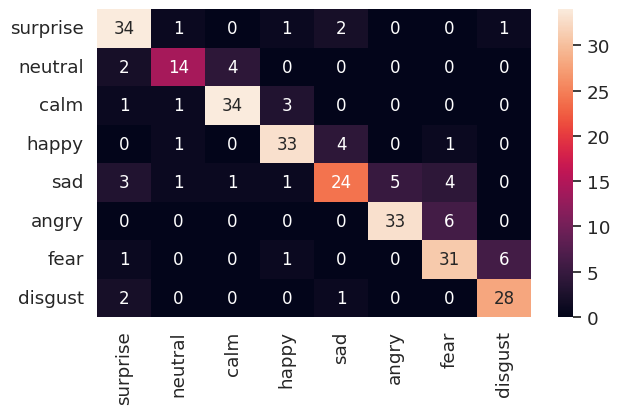

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Truncate Y_test to match the length of predictions
min_length = min(len(Y_test), len(predictions))
Y_test_aligned = Y_test[:min_length]
predictions_aligned = predictions[:min_length]

# Compute the confusion matrix
cm = confusion_matrix(Y_test_aligned, predictions_aligned)

# Assuming EMOTIONS is a list of emotion labels
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]

# Convert confusion matrix to DataFrame for better visualization
df_cm = pd.DataFrame(cm, index=names, columns=names)

# Plot the confusion matrix
plt.figure(figsize=(7, 4))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.show()


confusion matrix

correlation between emotion intensity and corectness

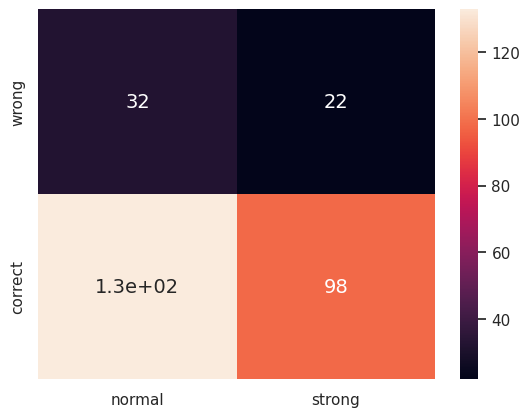

In [29]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Truncate Y_test and predictions to match the length of the shorter array
min_length = min(len(Y_test), len(predictions))
Y_test_aligned = Y_test[:min_length]
predictions_aligned = predictions[:min_length]

correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0

for i in range(min_length):
    intensity = data.loc[test_ind[i], 'Emotion intensity']
    if Y_test_aligned[i] == predictions_aligned[i]:
        if intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else:  # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1

# Create an array for visualization
array = np.array([[wrong_normal, wrong_strong], [correct_normal, correct_strong]])
df = pd.DataFrame(array, index=['wrong', 'correct'], columns=['normal', 'strong'])

# Plot the heatmap
sn.set(font_scale=1.0)  # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 14})
plt.show()


correlation between gender and corectness

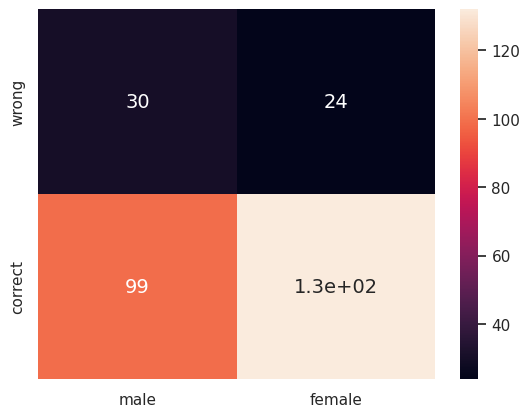

In [30]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Truncate Y_test and predictions to match the length of the shorter array
min_length = min(len(Y_test), len(predictions))
Y_test_aligned = Y_test[:min_length]
predictions_aligned = predictions[:min_length]
test_ind_aligned = test_ind[:min_length]

correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0

for i in range(min_length):
    gender = data.loc[test_ind_aligned[i], 'Gender']
    if Y_test_aligned[i] == predictions_aligned[i]:
        if gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else:  # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1

# Create an array for visualization
array = np.array([[wrong_male, wrong_female], [correct_male, correct_female]])
df = pd.DataFrame(array, index=['wrong', 'correct'], columns=['male', 'female'])

# Plot the heatmap
sn.set(font_scale=1.0)  # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 14})
plt.show()


# Plot loss

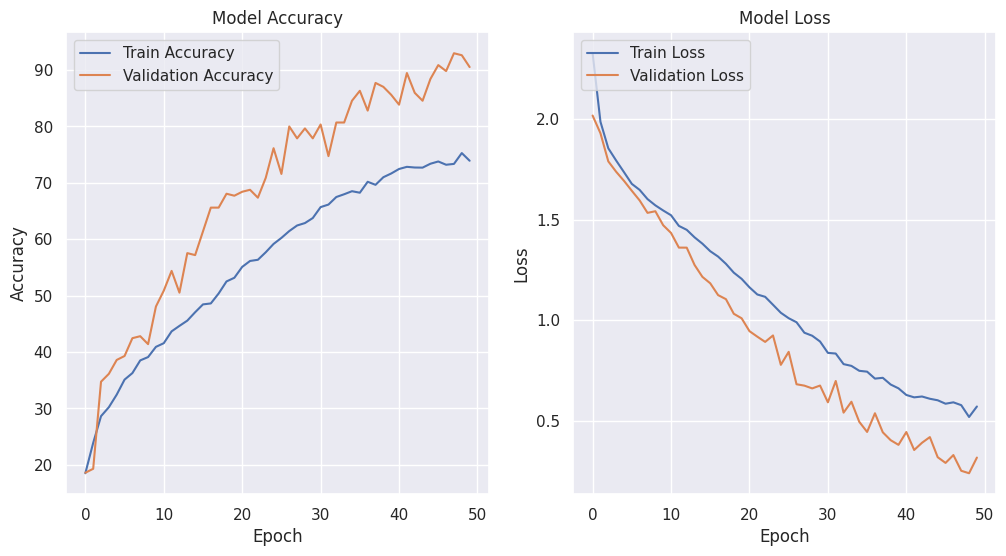

In [31]:
import matplotlib.pyplot as plt

# Define the lists from the training process
train_losses = [
    2.3251, 1.9853, 1.8537, 1.7930, 1.7353, 1.6771, 1.6472, 1.6017, 1.5706, 1.5451, 
    1.5215, 1.4687, 1.4492, 1.4119, 1.3805, 1.3431, 1.3165, 1.2805, 1.2368, 1.2060, 
    1.1640, 1.1285, 1.1169, 1.0775, 1.0377, 1.0108, 0.9907, 0.9388, 0.9238, 0.8952, 
    0.8388, 0.8355, 0.7830, 0.7743, 0.7499, 0.7456, 0.7112, 0.7151, 0.6819, 0.6629, 
    0.6300, 0.6182, 0.6224, 0.6112, 0.6037, 0.5866, 0.5935, 0.5795, 0.5208, 0.5728
]

val_losses = [
    2.0161, 1.9282, 1.7888, 1.7373, 1.6922, 1.6428, 1.5949, 1.5334, 1.5414, 1.4719, 
    1.4337, 1.3610, 1.3608, 1.2748, 1.2158, 1.1839, 1.1254, 1.1052, 1.0328, 1.0103, 
    0.9466, 0.9192, 0.8932, 0.9252, 0.7795, 0.8439, 0.6832, 0.6763, 0.6626, 0.6767, 
    0.5936, 0.6994, 0.5424, 0.5964, 0.4968, 0.4466, 0.5393, 0.4448, 0.4058, 0.3826, 
    0.4462, 0.3571, 0.3929, 0.4211, 0.3213, 0.2930, 0.3319, 0.2540, 0.2417, 0.3195
]

# Training and validation accuracies
train_accuracies = [
    18.51, 23.89, 28.63, 30.22, 32.45, 35.11, 36.27, 38.52, 39.11, 40.92, 
    41.57, 43.67, 44.64, 45.57, 47.06, 48.45, 48.62, 50.39, 52.52, 53.17, 
    55.10, 56.15, 56.36, 57.69, 59.17, 60.24, 61.45, 62.44, 62.87, 63.76, 
    65.70, 66.15, 67.49, 67.98, 68.52, 68.25, 70.19, 69.65, 71.00, 71.66, 
    72.46, 72.84, 72.72, 72.70, 73.39, 73.79, 73.21, 73.36, 75.28, 73.92
]

val_accuracies = [
    18.60, 19.30, 34.74, 36.14, 38.60, 39.30, 42.46, 42.81, 41.40, 48.07, 
    50.88, 54.39, 50.53, 57.54, 57.19, 61.40, 65.61, 65.61, 68.07, 67.72, 
    68.42, 68.77, 67.37, 70.88, 76.14, 71.58, 80.00, 77.89, 79.65, 77.89, 
    80.35, 74.74, 80.70, 80.70, 84.56, 86.32, 82.81, 87.72, 87.02, 85.61, 
    83.86, 89.47, 85.96, 84.56, 88.42, 90.88, 89.82, 92.98, 92.63, 90.53
]



# Plotting
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Save plots to a file
plt.savefig('model_performance.png')

# Show plots
plt.show()
